In [25]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import plotly
import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import os

np.random.seed(10)

In [15]:
os.chdir("/Users/NNK/Documents/project/kaggle/houseprices")

htrain = pd.read_csv('train.csv')
htest = pd.read_csv('test.csv')

#Basic transformations
htrain = htrain.drop('Id', axis=1)

###
##   Note: change "YearBuilt", "YearSold", "YearRM"
#       to "Years Since" vars..
##
###
htrain['YrsOld'] = 2017 - htrain['YearBuilt']
htrain['YrsRM'] = 2017 - htrain['YearRemodAdd']
htrain['YrsSS'] = 2017 - htrain['YrSold']

htrain = htrain.drop(['YearBuilt','YearRemodAdd','YrSold'],axis=1)

htrain['TotalSF'] = htrain.GrLivArea + htrain.TotalBsmtSF

pd.set_option('display.max_columns', len(list(htrain))) 
htrain.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,YrsOld,YrsRM,YrsSS,TotalSF
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,WD,Normal,208500,14,14,9,2566
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,WD,Normal,181500,41,41,10,2524
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,WD,Normal,223500,16,15,9,2706
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,WD,Abnorml,140000,102,47,11,2473
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,WD,Normal,250000,17,17,9,3343
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,WD,Normal,143000,24,22,8,2158
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,WD,Normal,307000,13,12,10,3380
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,WD,Normal,200000,44,44,8,3197
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,WD,Abnorml,129900,86,67,9,2726
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,T

In [18]:
#%%
# Clean data and convert to all numeric.
#-------------------------

# Fill NAs with 0 first step
htrain = htrain.fillna(value=0)
#htrain = htrain.dropna(axis=1)


#Get Dummy Variables 
sd_cols = pd.get_dummies(htrain.SaleCondition, prefix='SaleCon')
bt_cols = pd.get_dummies(htrain.BldgType, prefix='BldgType')
style_cols = pd.get_dummies(htrain.HouseStyle, prefix='HouseStyle')
ms_cols = pd.get_dummies(htrain.Exterior1st, prefix='Exterior1st')
nb_cols = pd.get_dummies(htrain.GarageType, prefix='GarageType')
htrain = pd.concat([htrain,sd_cols, bt_cols, style_cols,
                    ms_cols, nb_cols], axis=1)

In [20]:
# Convert dataframe to all numeric for training models
#
#-------------------------

#1.) Seperate numerical and non-numerical columns into dataframes
numht = htrain.select_dtypes(include = ['float64','int64'])
nonht = htrain.select_dtypes(exclude = ['float64','int64'])

# -- Get Category Codes --
#2.) Create empty df and pass all columns from non-numeric df 
# converted to categorical
non2 = pd.DataFrame()
for column in nonht:
    non2[column] = pd.Categorical(nonht[column])

#3.) Create another empty df and pass all columns from categorical df
# converted to codes    
nonC = pd.DataFrame()
for column in non2:
    nonC[column] = non2[column].cat.codes
    
#Combine the native numerical and newly converted dataframes
trNum = pd.concat([numht,nonC], axis=1)
#Create normalized dataframe if needed
trNorm = (trNum - trNum.mean()) / (trNum.max() - trNum.min())

pd.set_option('display.max_columns', len(list(trNum))) 
trNum.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YrsOld,YrsRM,YrsSS,TotalSF,SaleCon_Abnorml,SaleCon_AdjLand,SaleCon_Alloca,SaleCon_Family,SaleCon_Normal,SaleCon_Partial,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,GarageType_0,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,208500,14,14,9,2566,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1,0,3,3,0,4,0,5,2,2,0,5,1,1,12,13,2,2,4,2,3,4,4,3,6,1,0,1,5,2,6,0,2,2,5,5,2,0,0,0,8,4
1,20,80.0,9600,6,8,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,181500,41,41,10,2524,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1,0,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,3,4,2,1,6,1,0,1,5,3,6,5,2,2,5,5,2,0,0,0,8,4
2,60,68.0,11250,7,5,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,223500,16,15,9,2706,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1,0,0,3,0,4,0,5,2,2,0,5,1,1,12,13,2,2,4,2,3,4,3,3,6,1,0,1,5,2,6,5,2,2,5,5,2,0,0,0,8,4
3,70,60.0,9550,7,5,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,140000,102,47,11,2473,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,1,0,0,3,0,0,0,6,2,2,0,5,1,1,13,15,3,3,4,0,4,2,4,1,6,1,2,1,5,2,6,3,6,3,5,5,2,0,0,0,8,0
4,60,84.0,14260,8,5,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,250000,17,17,9,3343,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1,0,0,3,0,2,0,15,2,2,0,5,1,1,12,13,2,2,4,2,3,4,1,3,6,1,0,1,5,2,6,5,2,2,5,5,2,0,0,0,8,4
5,50,85.0,14115,5,5,0.0,732,0,64,796,796,566,0,1362,1,0,1,1,1,1,5,0,1993.0,2,480,40,30,0,320,0,0,700,10,143000,24,22,8,2158,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1,0,0,3,0,4,0,11,2,2,0,0,1,1,12,13,3,3,4,5,3,4,4,3,6,1,0,1,5,3,6,0,2,3,5,5,2,0,3,3,8,4
6,20,75.0,10084,8,5,186.0,1369,0,317,1686,1694,0,0,1694,1,0,2,0,3,1,7,1,2004.0,2,636,255,57,0,0,0,0,0,8,307000,13,12,10,3380,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

<h3> Exploratory Data Analysis </h3>

- Correlation Plots

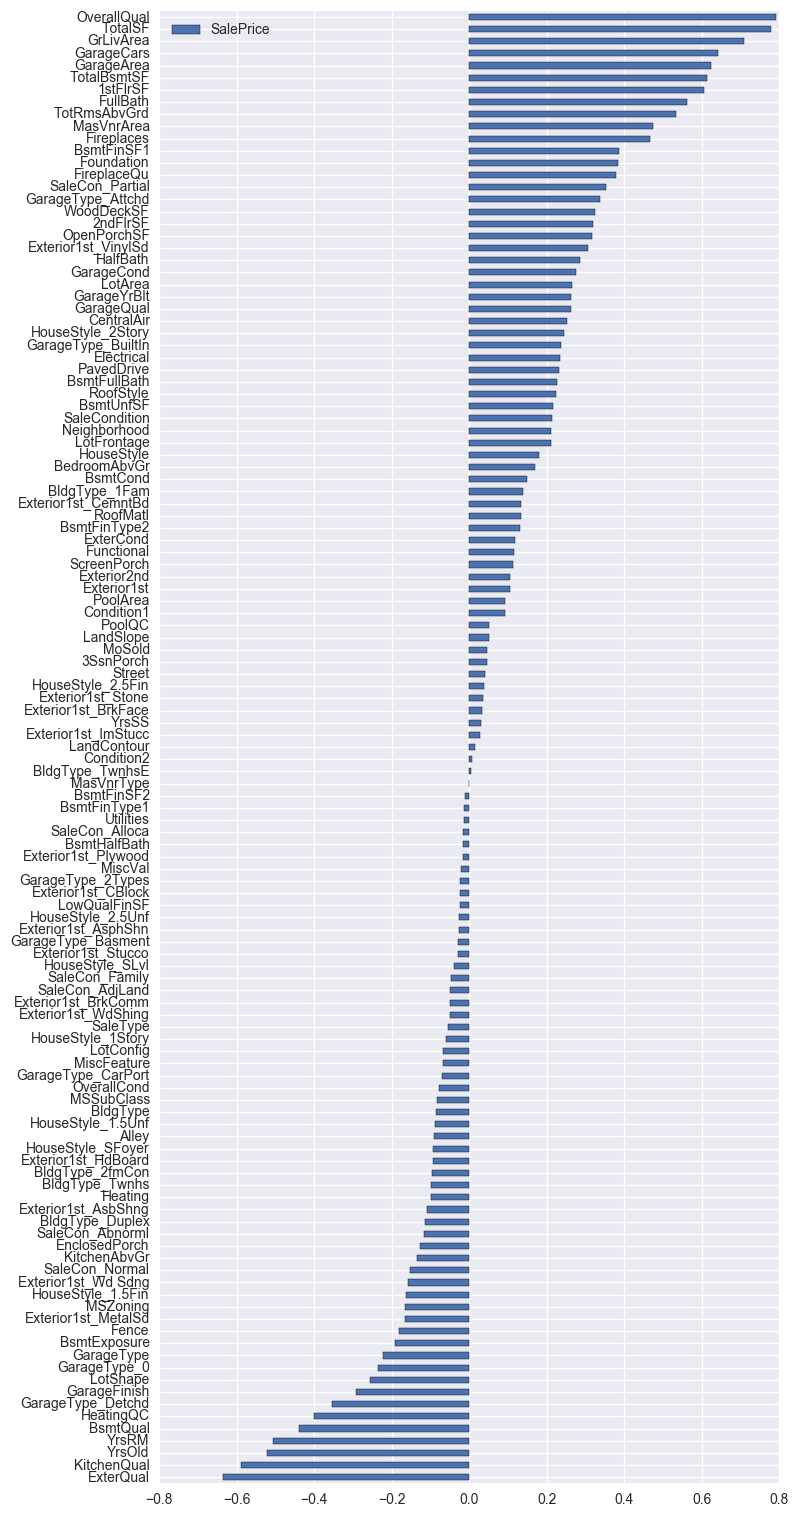

In [23]:
#     >>> Correlation Plots

plt.rcParams['figure.figsize']=(8,19)
corrdf = trNum.corr()
ycorr = corrdf[['SalePrice']]
ycorr = ycorr.sort_values(by=['SalePrice'])
ycorr.drop(['SalePrice']).plot(kind='barh')

- Set Plotly Creds

In [26]:
plotly.tools.set_credentials_file(username='sampsonsimpson', 
                                  api_key='cxm2iF7KKBGZgXmDOU9S')

In [28]:


layout = go.Layout(
        title='House Price vs. Living Area'
        )

d = [
     go.Scatter(
             x=trNum['GrLivArea'],
             y=trNum['SalePrice'],
             mode = "markers",
             marker= dict(size= 14,
                    line= dict(width=1),
                    color= trNum['SalePrice'],
                    opacity= 0.7
                   ))]


fig = go.Figure(data=d, layout=layout)

cf.iplot(fig, filename='house-prices')

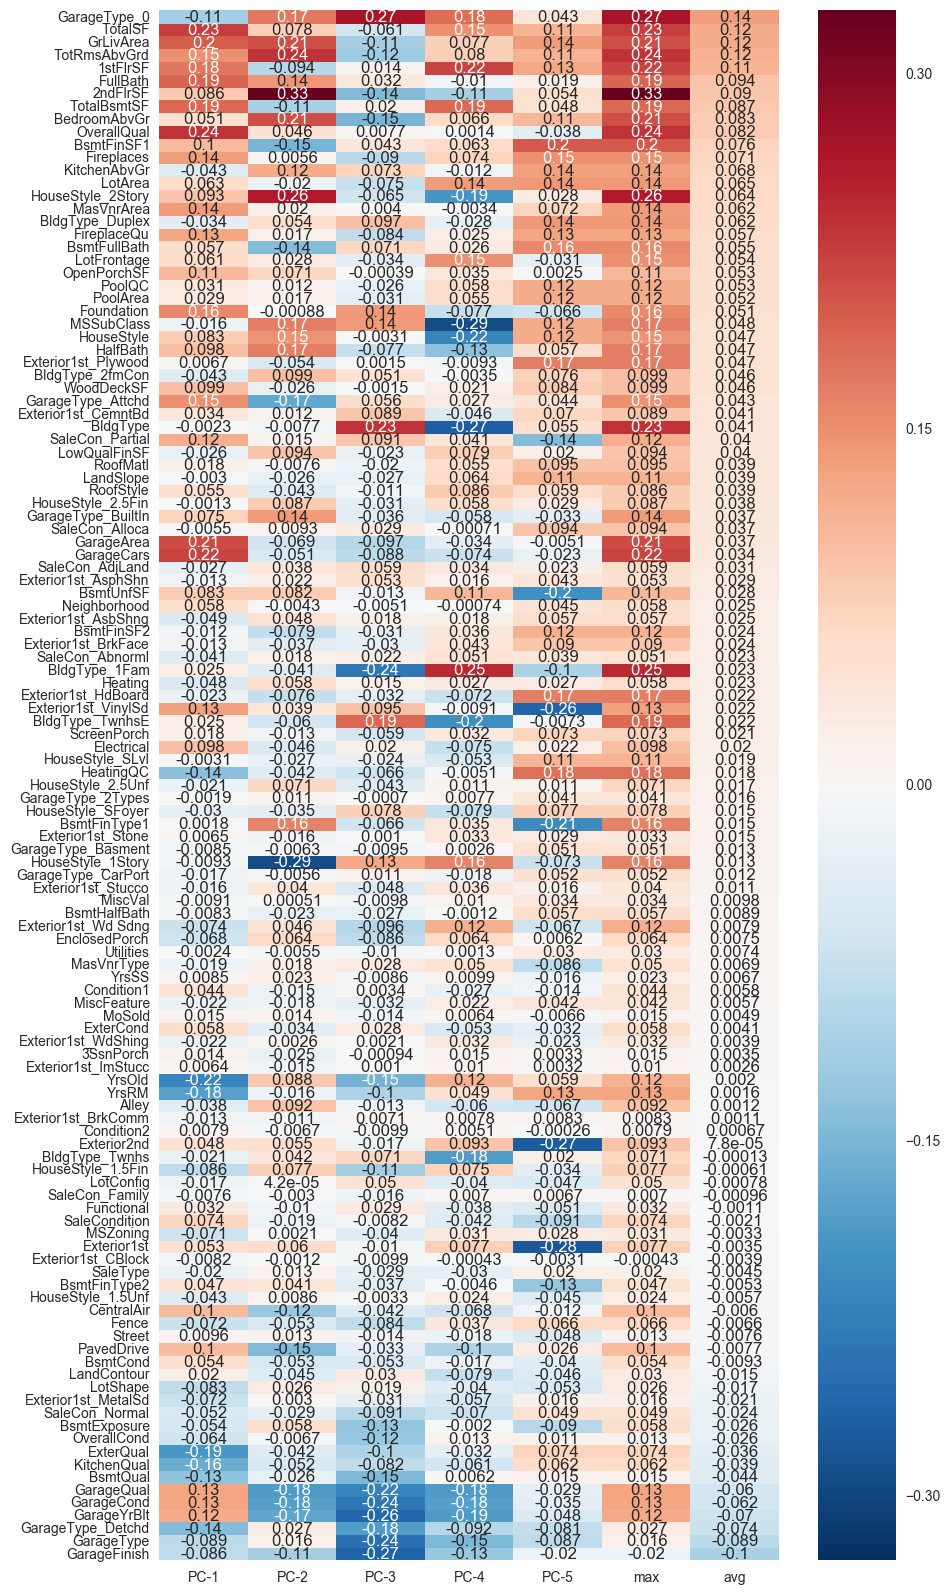

In [31]:
#%% 
#       =========  #PCA  --- Principal Components ==========

#-------------------------------------------------------------------

#Create a different normalized dataframe for PCA
trPCA = (trNum - trNum.mean()) / trNum.std()

i = np.identity(trPCA.drop('SalePrice', axis=1).shape[1])

pca = PCA(n_components=5, random_state=1010)
pca.fit_transform(trPCA.drop('SalePrice', axis=1).values)

coef = pca.transform(i)
pcp = pd.DataFrame(coef, columns = ['PC-1','PC-2','PC-3','PC-4','PC-5'],
                           index = trPCA.drop('SalePrice', axis=1).columns)

#%% Visualize Principal components

pcp['max'] = pcp.max(axis=1)
pcp['avg'] = pcp.mean(axis=1)


pcp = pcp.sort_values(by=['avg'], ascending=False)

plt.rcParams['figure.figsize']=(10,20)
sb.heatmap(pcp, annot=True, annot_kws={"size": 12})

In [32]:
#%%
# -----  -----  save top components

#conditional top
top = list(pcp[(pcp['max'] > pcp['max'].mean())].index)

#sorted list
pclist = list(pcp.index)

#%%
#<> ----  Create new train and test sets based on top principal components ---
#<><>
#<><><>
#<><><><>
#Set up training and test sets (below using all variables, but code
#                               easily modified)

pcdata = pd.concat([trNum[pclist[0:len(pclist)]],trNum['SalePrice']],axis=1)
nmdata = pd.concat([trNorm[pclist[0:len(pclist)]],trNorm['SalePrice']],axis=1)
#nmonly = pd.concat([trNum_norm[list(numht.drop('SalePrice',axis=1))],trNum_norm['SalePrice']],axis=1)

train, test = train_test_split(pcdata, test_size = .30, random_state = 1010)

# Train outcome and predictors 
y = train.SalePrice
X = train.drop('SalePrice', axis=1)

# Test outcome and predictors
yt = test.SalePrice
Xt = test.drop('SalePrice', axis=1)

# Create normalized train and test sets

train, test = train_test_split(nmdata, test_size = .30, random_state = 1010)

ynorm = train.SalePrice
Xnorm = train.drop('SalePrice', axis=1)

ytnorm = test.SalePrice
Xtnorm = test.drop('SalePrice', axis=1)

In [35]:
#%%
#               ## ==== Model Training ==== ##
#
#               ## ==== Gradient Boosting Regressor ==== ##

#-----------------------------------------------------------------
#Set model parameters
gbfit = GradientBoostingRegressor(n_estimators=250, loss='ls', random_state=1010)

#Fit model
gbfit.fit(X=X, y=y)

#%% explore GB fit
accuracy = gbfit.score(Xt, yt)
predict = gbfit.predict(Xt)


#%%
gbr_results = pd.DataFrame({'Predicted':predict,
                            'Ground Truth':yt})

print('Gradient Boosting Accuracy %s' % '{0:.2%}'.format(accuracy))    
gbr_results.iplot(kind='scatter',mode='markers',x='Predicted',y='Ground Truth',
                  title='GBR Prediction Results',
                  xTitle='Predicted', 
                  yTitle='Ground Truth',
                  filename='predicted-groundtruth')



Gradient Boosting Accuracy 91.90%


Feature Importances


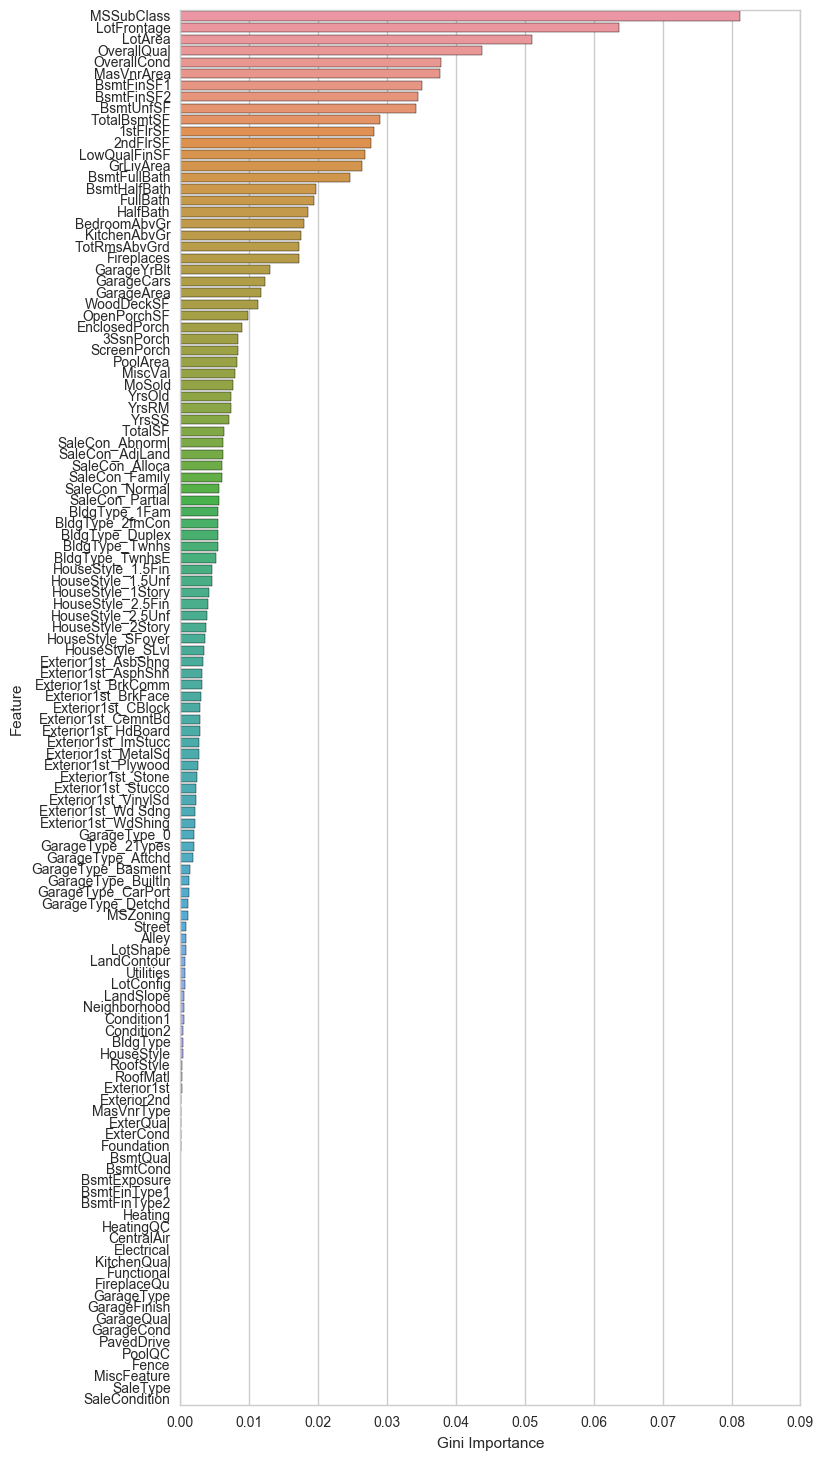

In [40]:
#%%
# Model feature importances ranking
importances = gbfit.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Importances')

#for f in range(X.shape[1]):
#    print("feature %s (%f)" % (list(X)[f], importances[indices[f]]))

#plot
feat_imp = pd.DataFrame({'Feature':list(X),
                         'Gini Importance':importances[indices]})

plt.rcParams['figure.figsize']=(8,18)
sb.set_style('whitegrid')
ax = sb.barplot(x='Gini Importance', y='Feature', data=feat_imp)
ax.set(xlabel='Gini Importance')
plt.show()    


#_________________________________________________________________________________> 

# End Gradient Boosting .. 
#_________________________________________________________________________________>  
#_________________________________________________________________________________>  
#_________________________________________________________________________________>    
#########


In [36]:
  #%%
# -------------- Create Bins for SalesPrice Variable --------------------
# ...
## ... for use with Classification Models


#bins = [0,100000,150000,200000,250000,300000,350000,400000,
##       450000,500000,550000,600000,650000,700000]

# .. need to create labels vector for 'mix type error (string and num)

bins=5
trNum['PriceRange'] = pd.cut(trNum.SalePrice, bins)
trNorm['PriceRange'] = pd.cut(trNum.SalePrice, bins)

#%%
#Set up training and test sets for classification

#cats = pd.concat([trNum_norm,trNum_norm['PriceRange']],axis=1)
cats = trNorm.drop('SalePrice',axis=1)
train, test = train_test_split(cats, test_size = .25, random_state=10)

# Train outcome and predictors 
y = train.PriceRange
X = train.drop('PriceRange', axis=1)

# Test outcome and predictors
yt = test.PriceRange
Xt = test.drop('PriceRange', axis=1)

trNum.PriceRange.value_counts()


(34179.9, 178920]    871
(178920, 322940]     508
(322940, 466960]      70
(466960, 610980]       7
(610980, 755000]       4
Name: PriceRange, dtype: int64

<hr></h2>**Classification Models**</h2>

In [38]:
#%%
# >>>>>>>>>>>>>>> Random Forest <<<<<<<<<<<<<<<<<<<<<

forest = RandomForestClassifier(n_estimators=1000, random_state=1010)
rfit = forest.fit(X,y)
accuracy = rfit.score(Xt,yt)

print('Random Forest Accuracy %s' % '{0:.2%}'.format(accuracy))


Random Forest Accuracy 86.85%
